In [103]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Dict, Any, List, Tuple
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, confusion_matrix

# Set a style for our plots
sns.set_style("whitegrid")

# set pandas parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("Libraries imported successfully.")

Libraries imported successfully.


```
Phase 1: Data Collection and Preparation
Task 1.1: Load the dataset from here.
Task 1.2: Load the dataset into a Pandas DataFrame.
Task 1.3: Inspect the dataset for missing values and handle them appropriately.
Task 1.4: Perform data cleaning to ensure the dataset is ready for analysis.


In [104]:
def load_data_from_url(url: str) -> Optional[pd.DataFrame]:
    """
    Attempts to load a CSV from a URL into a DataFrame.
    Returns the DataFrame on success or None on failure.
    """
    try:
        response = pd.read_csv(url)
        if response is not None:
            print("--- Data Loaded Successfully ---")
            print(response.head())
            return response
        else:
            print("Data loading failed.")
            return None
    except Exception as e:
        print(f"Error loading data from {url}: {e}")
        return None


DATA_URL = r"https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/EasyVisa%20(1).csv"

data = load_data_from_url(DATA_URL)



--- Data Loaded Successfully ---
  case_id continent education_of_employee has_job_experience  \
0  EZYV01      Asia           High School                  N   
1  EZYV02      Asia              Master's                  Y   
2  EZYV03      Asia            Bachelor's                  N   
3  EZYV04      Asia            Bachelor's                  N   
4  EZYV05    Africa              Master's                  Y   

  requires_job_training  no_of_employees  yr_of_estab region_of_employment  \
0                     N            14513         2007                 West   
1                     N             2412         2002            Northeast   
2                     Y            44444         2008                 West   
3                     N               98         1897                 West   
4                     N             1082         2005                South   

   prevailing_wage unit_of_wage full_time_position case_status  
0         592.2029         Hour                 

In [105]:
def get_missing_value_counts(df: pd.DataFrame) -> pd.Series:
    """Calculates the count of nulls for each column."""
    return df.isnull().sum()


def get_duplicate_row_count(df: pd.DataFrame) -> int:
    """Calculates the total number of duplicate rows."""
    return df.duplicated().sum()


missing_counts = get_missing_value_counts(data)
duplicate_count = get_duplicate_row_count(data)
print("\n--- Missing Value Counts ---")
print(missing_counts)

print(f"\n--- Duplicate Rows ---")
print(duplicate_count)


--- Missing Value Counts ---
case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

--- Duplicate Rows ---
0


```
# Phase 2: Exploratory Data Analysis (EDA)
Task 2.1: Conduct exploratory data analysis to understand the distribution of features and the target variable .
Task 2.2: Visualize the relationships between features and the target variable using scatter plots, histograms, and box plots.
Task 2.3: Identify and handle outliers in the dataset.

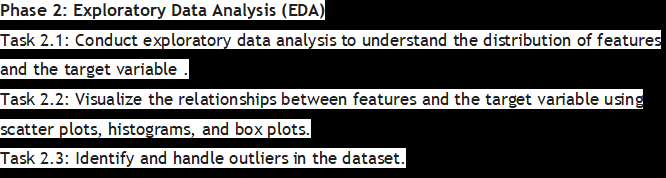
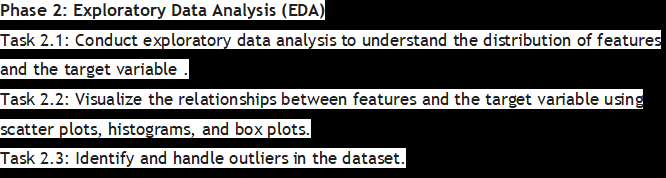

In [106]:
def get_statistical_description(df: pd.DataFrame) -> pd.DataFrame:
    """Returns the .describe() output for numerical columns."""
    return df.describe()


def get_skewness(df: pd.DataFrame) -> pd.Series:
    """Returns the skewness for numerical columns."""
    return df.skew(numeric_only=True)


print("--- Statistical Description of Numerical Data ---")
print(get_statistical_description(data))

print("\n--- Skewness ---")
print(get_skewness(data))

--- Statistical Description of Numerical Data ---
       no_of_employees   yr_of_estab  prevailing_wage
count     25480.000000  25480.000000     25480.000000
mean       5667.043210   1979.409929     74455.814592
std       22877.928848     42.366929     52815.942327
min         -26.000000   1800.000000         2.136700
25%        1022.000000   1976.000000     34015.480000
50%        2109.000000   1997.000000     70308.210000
75%        3504.000000   2005.000000    107735.512500
max      602069.000000   2016.000000    319210.270000

--- Skewness ---
no_of_employees    12.265260
yr_of_estab        -2.037301
prevailing_wage     0.755776
dtype: float64


In [107]:
# visualize the distribution between the features and target varable
# Analyze the target variable 'case_status'
print("\n--- Target Variable Distribution (case_status) ---")
print(data['case_status'].value_counts())
print("\n--- Target Variable Proportions (case_status) ---")
print(data['case_status'].value_counts(normalize=True))


--- Target Variable Distribution (case_status) ---
case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

--- Target Variable Proportions (case_status) ---
case_status
Certified    0.667896
Denied       0.332104
Name: proportion, dtype: float64


## Insight:
```
The dataset is imbalanced. About 66.78 percent of the cases were approved("Certified") while   33.21% were rejected ("Denied"). This is important to remeber for modelling later

## Visualize the relationships between features and the target variable using scatter plots, histograms, and box plots.
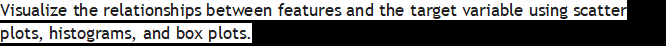

---Visual Distributions of Numerical Features---


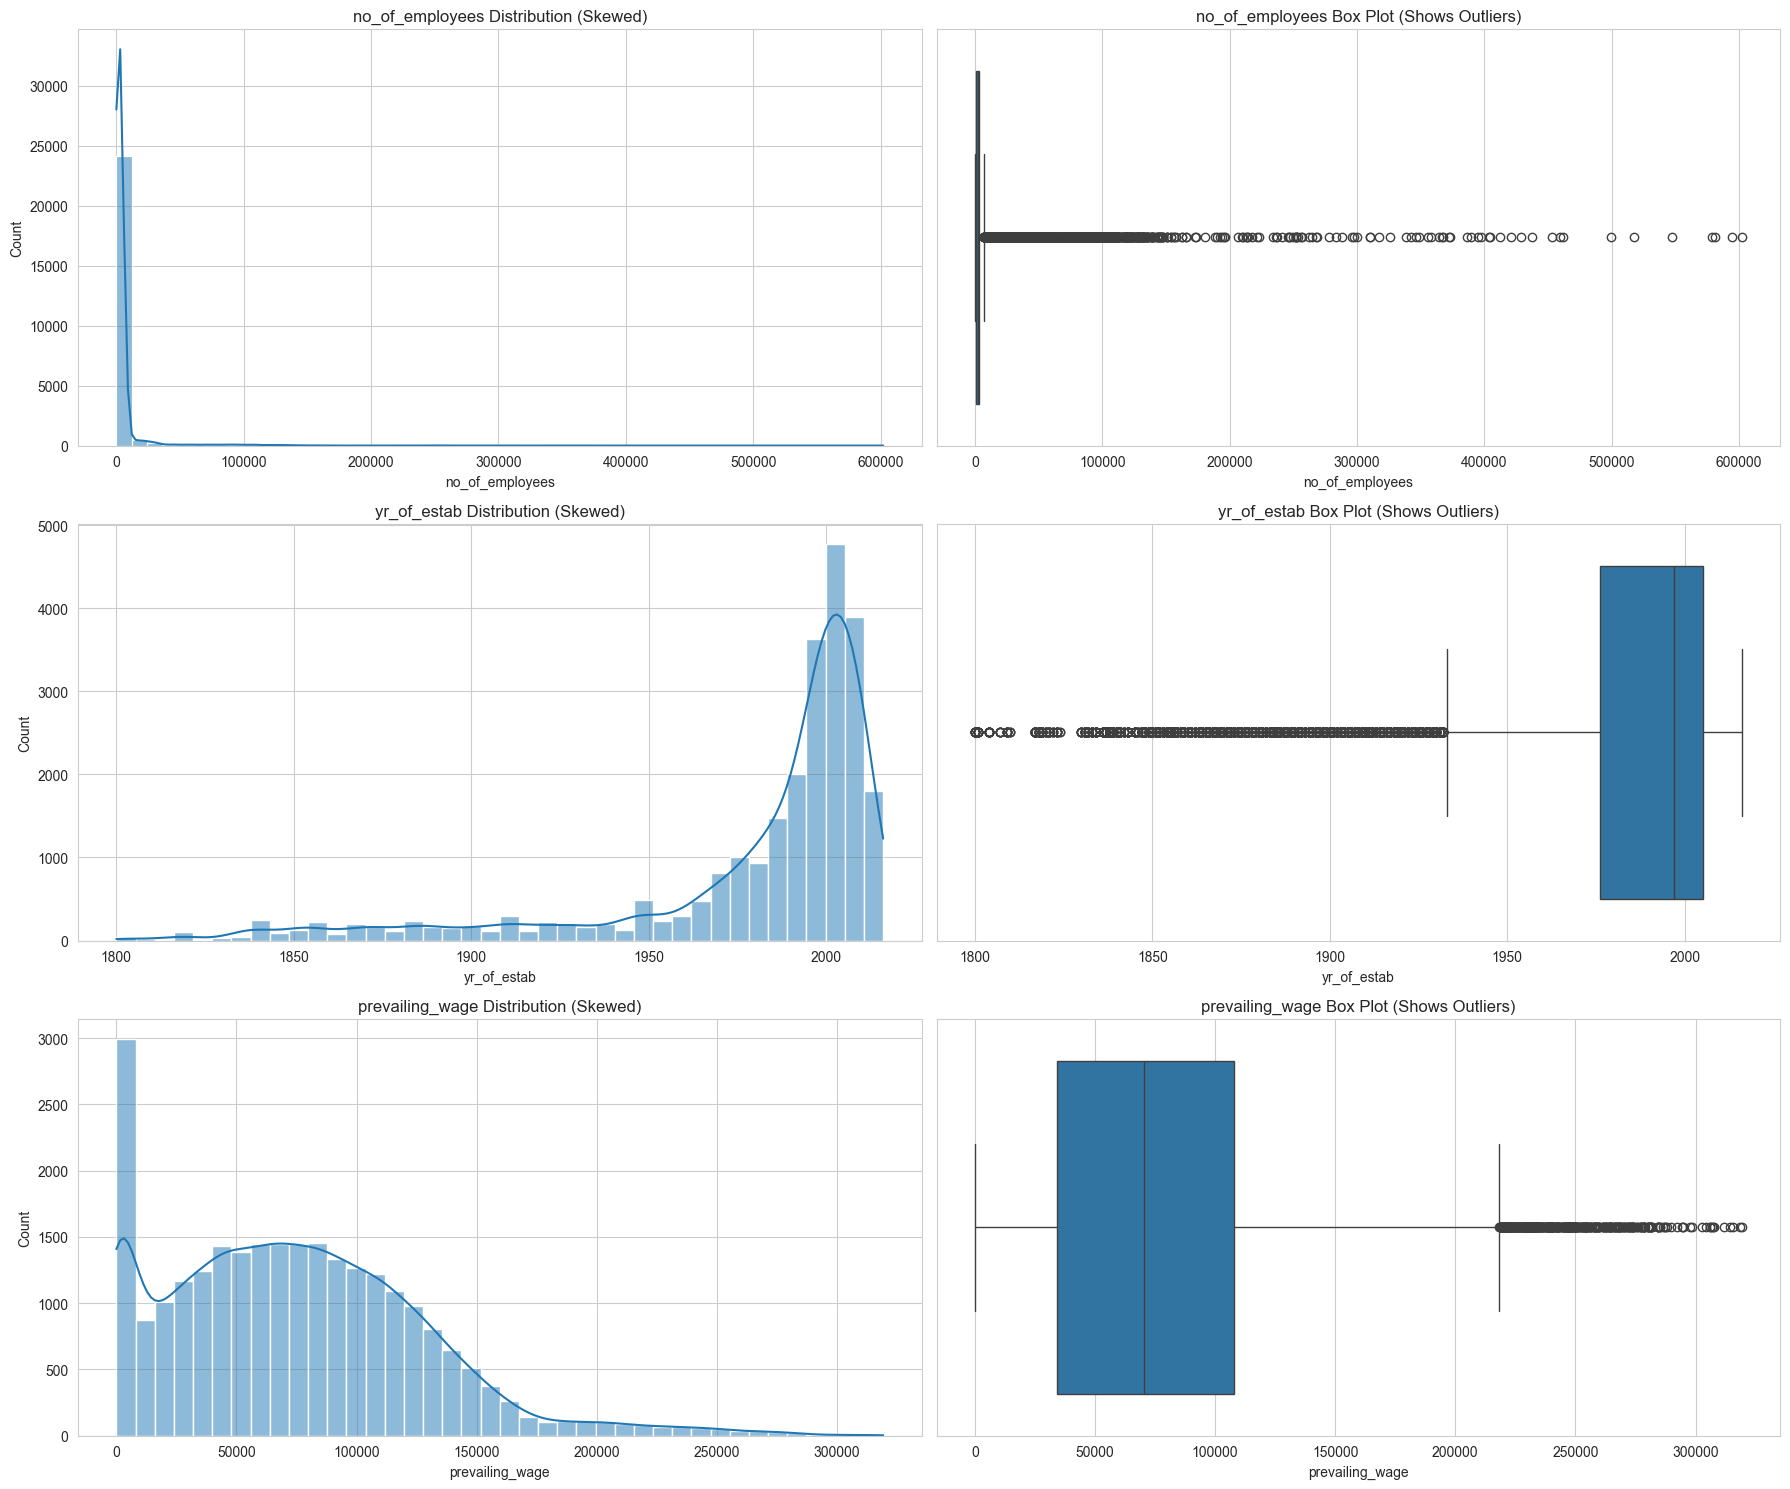

In [108]:
def plot_histogram(ax: plt.Axes, data: pd.Series, bins: int, title: str):
    """Takes a matplotlib axis and plots a histogram on it."""
    sns.histplot(data, kde=True, bins=bins, ax=ax)
    ax.set_title(title)


def plot_boxplot(ax: plt.Axes, data: pd.Series, title: str):
    """Takes a matplotlib axis and plots a boxplot on it."""
    sns.boxplot(x=data, ax=ax)
    ax.set_title(title)


numerical_features = ['no_of_employees', 'yr_of_estab', 'prevailing_wage']
plot_bins = [50, 40, 40]  # Bins for each feature

print("---Visual Distributions of Numerical Features---")
# Set up a figure for 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# We'll loop through our features and plot them
for i, feature in enumerate(numerical_features):
    # Get the specific data series
    data_series = data[feature]

    # Get the correct axes for this row
    hist_ax = axes[i, 0]
    box_ax = axes[i, 1]

    plot_histogram(hist_ax, data_series,
                   bins=plot_bins[i],
                   title=f'{feature} Distribution (Skewed)')

    plot_boxplot(box_ax, data_series,
                 title=f'{feature} Box Plot (Shows Outliers)')

plt.tight_layout()
plt.show()

#### Insights

    The visualizations confirm our findings from describe(). All three features are heavily skewed and have significant outliers.

    Prevailing Wage is interesting: a large number of applicants have 0 prevailing wage, creating a large spike at 0.

    This skewness suggests that for modeling, we might need to apply a log transformation to these features to normalize their distributions.

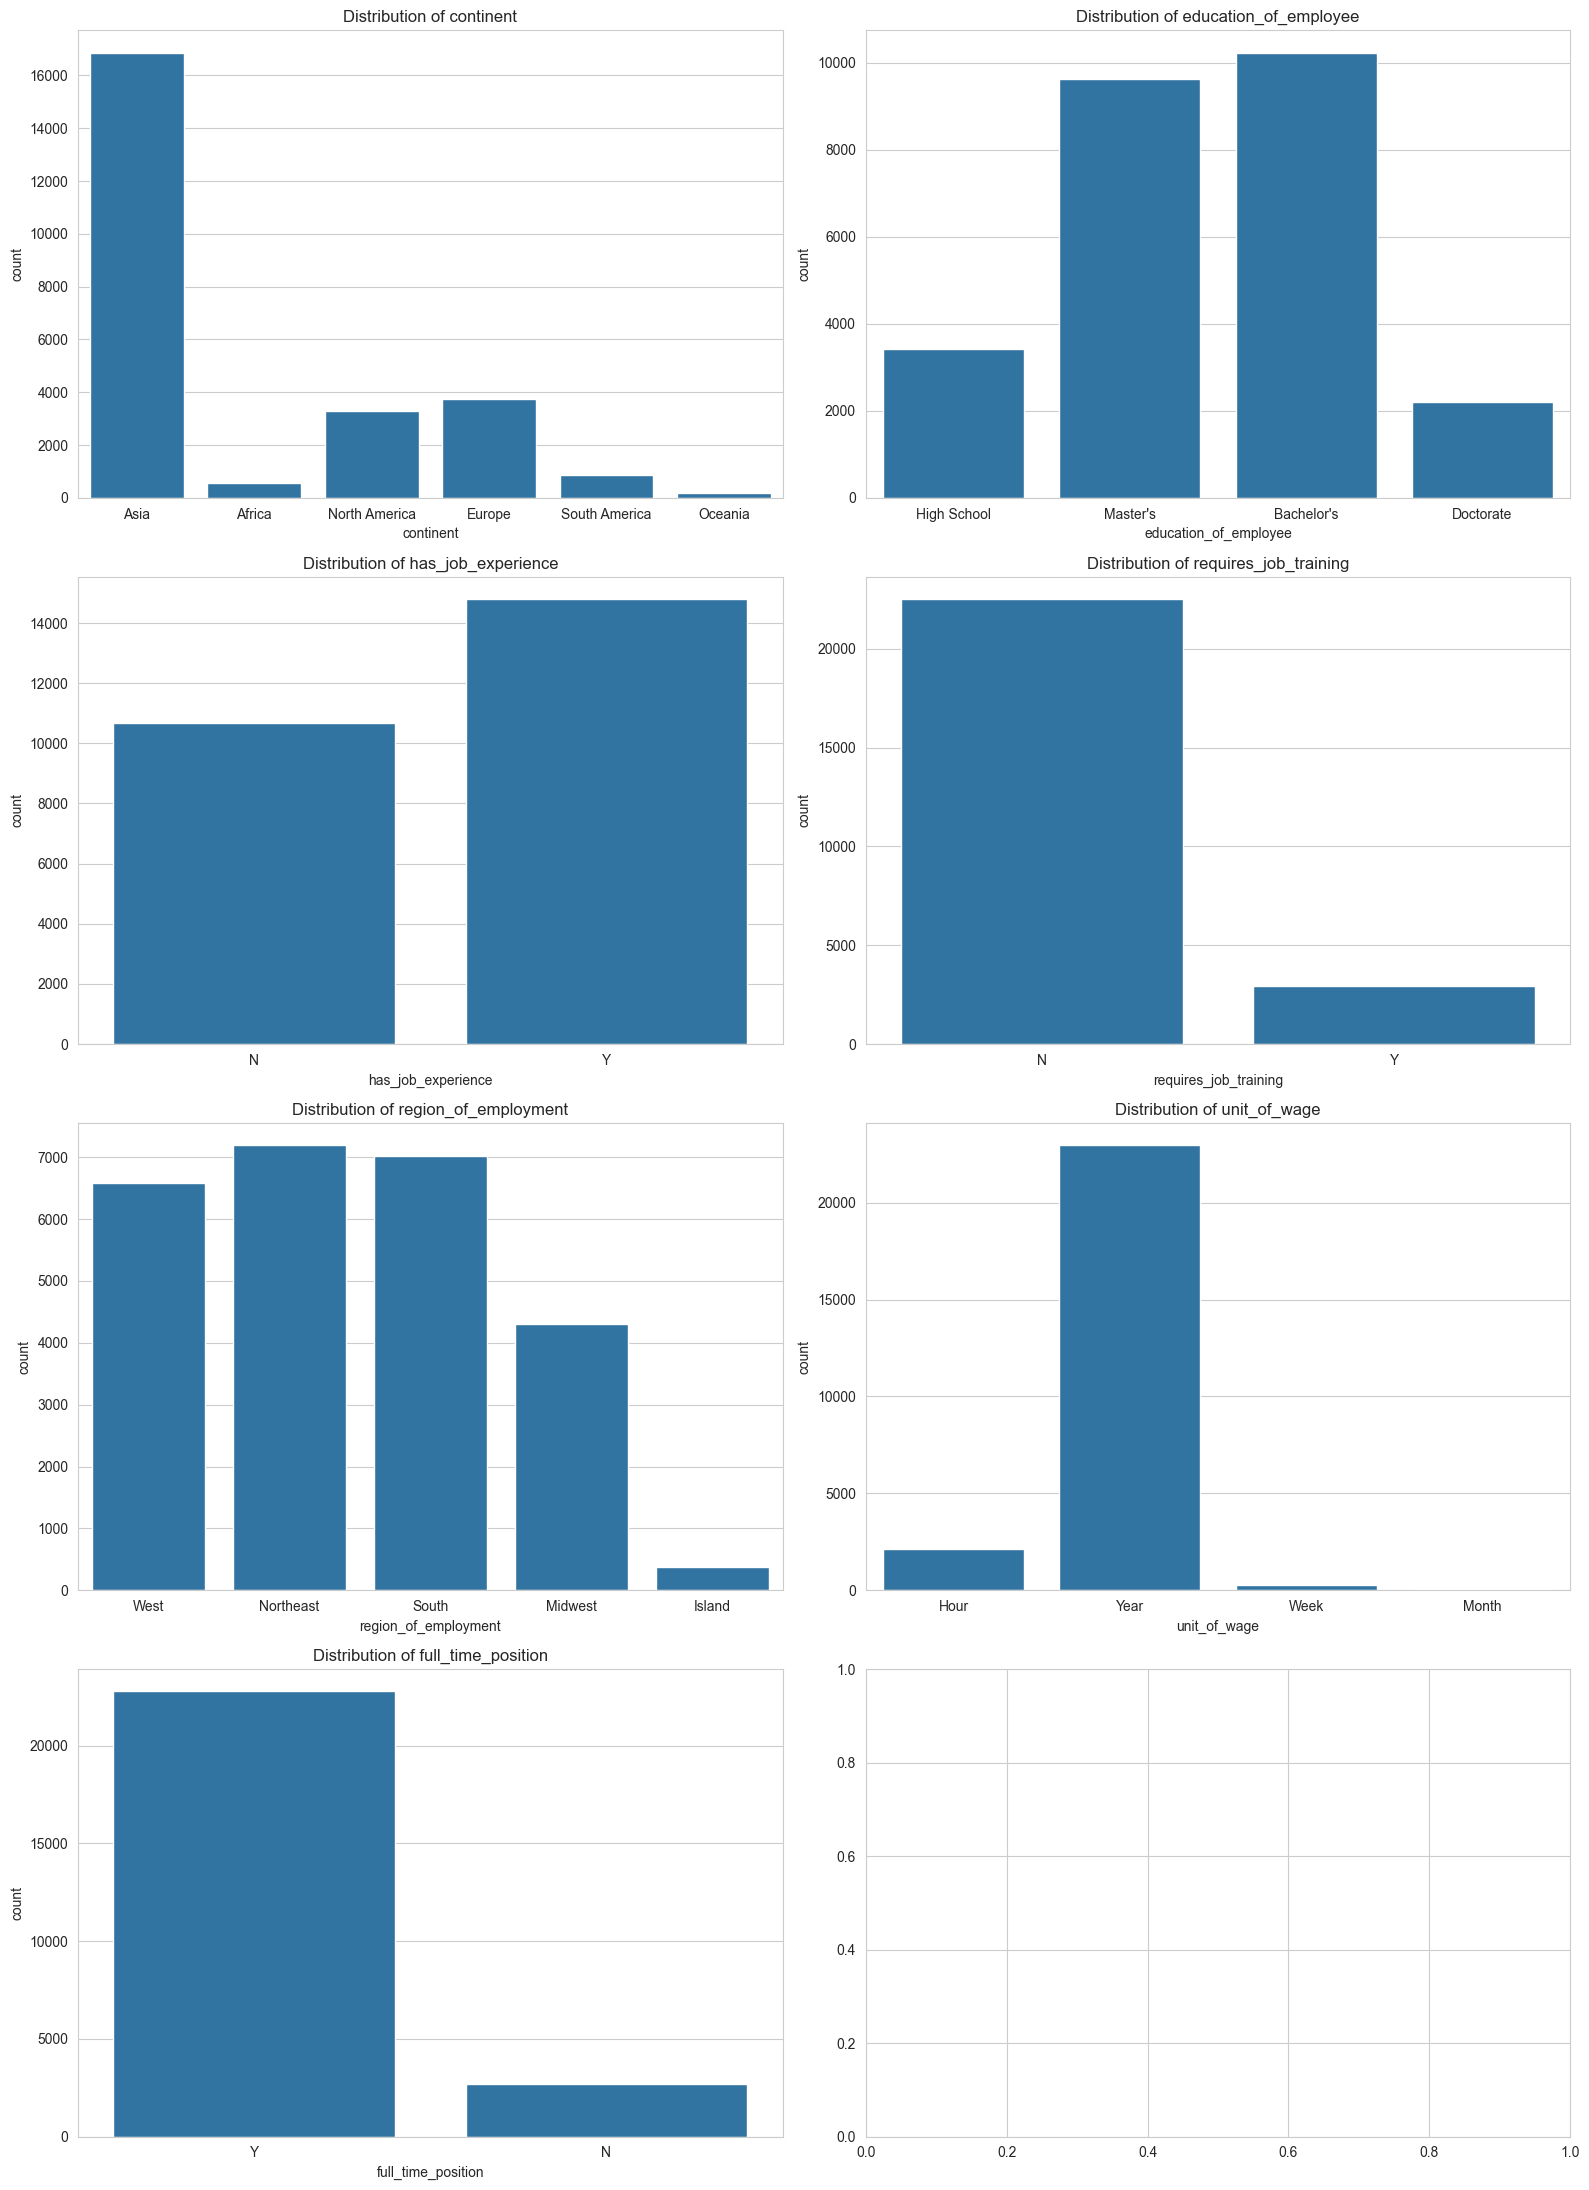

In [109]:
def plot_countplot_on_ax(ax: plt.Axes, data: pd.DataFrame, col: str):
    """
    Takes a matplotlib axis, plots a countplot for a specific column, and sets the title.
    """
    sns.countplot(x=col, data=data, ax=ax)
    ax.set_title(f'Distribution of {col}')


categorical_features = ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training',
                        'region_of_employment', 'unit_of_wage', 'full_time_position']

fig, axes = plt.subplots(4, 2, figsize=(16, 22))
axes_flat = axes.flatten()

for i, col in enumerate(categorical_features):
    plot_countplot_on_ax(ax=axes_flat[i], data=data, col=col)

plt.tight_layout()
plt.show()

#### Insights:
    continent: Majority of the Applicants are from Asia, then Europe, North America, South America, Africa and Oceania in that order

    education_of_employee: Majority of Applicants Have Either A Bachelor's or A Master's Degree, with fewer having just the High School Diploma or Doctorate

    has_job_experience: Job Experience is Split Fairly Evenly but with more apllicants having prior job experience

    requires_job_training: Majority of Applicants dont require Job Training

    region_of_employment:

    unit_of_wage: Most Applicants are to be paid per year

    full_time_position: Most Employers are offering full time positions


### Categorical Features Against Case Status (Target Variable)

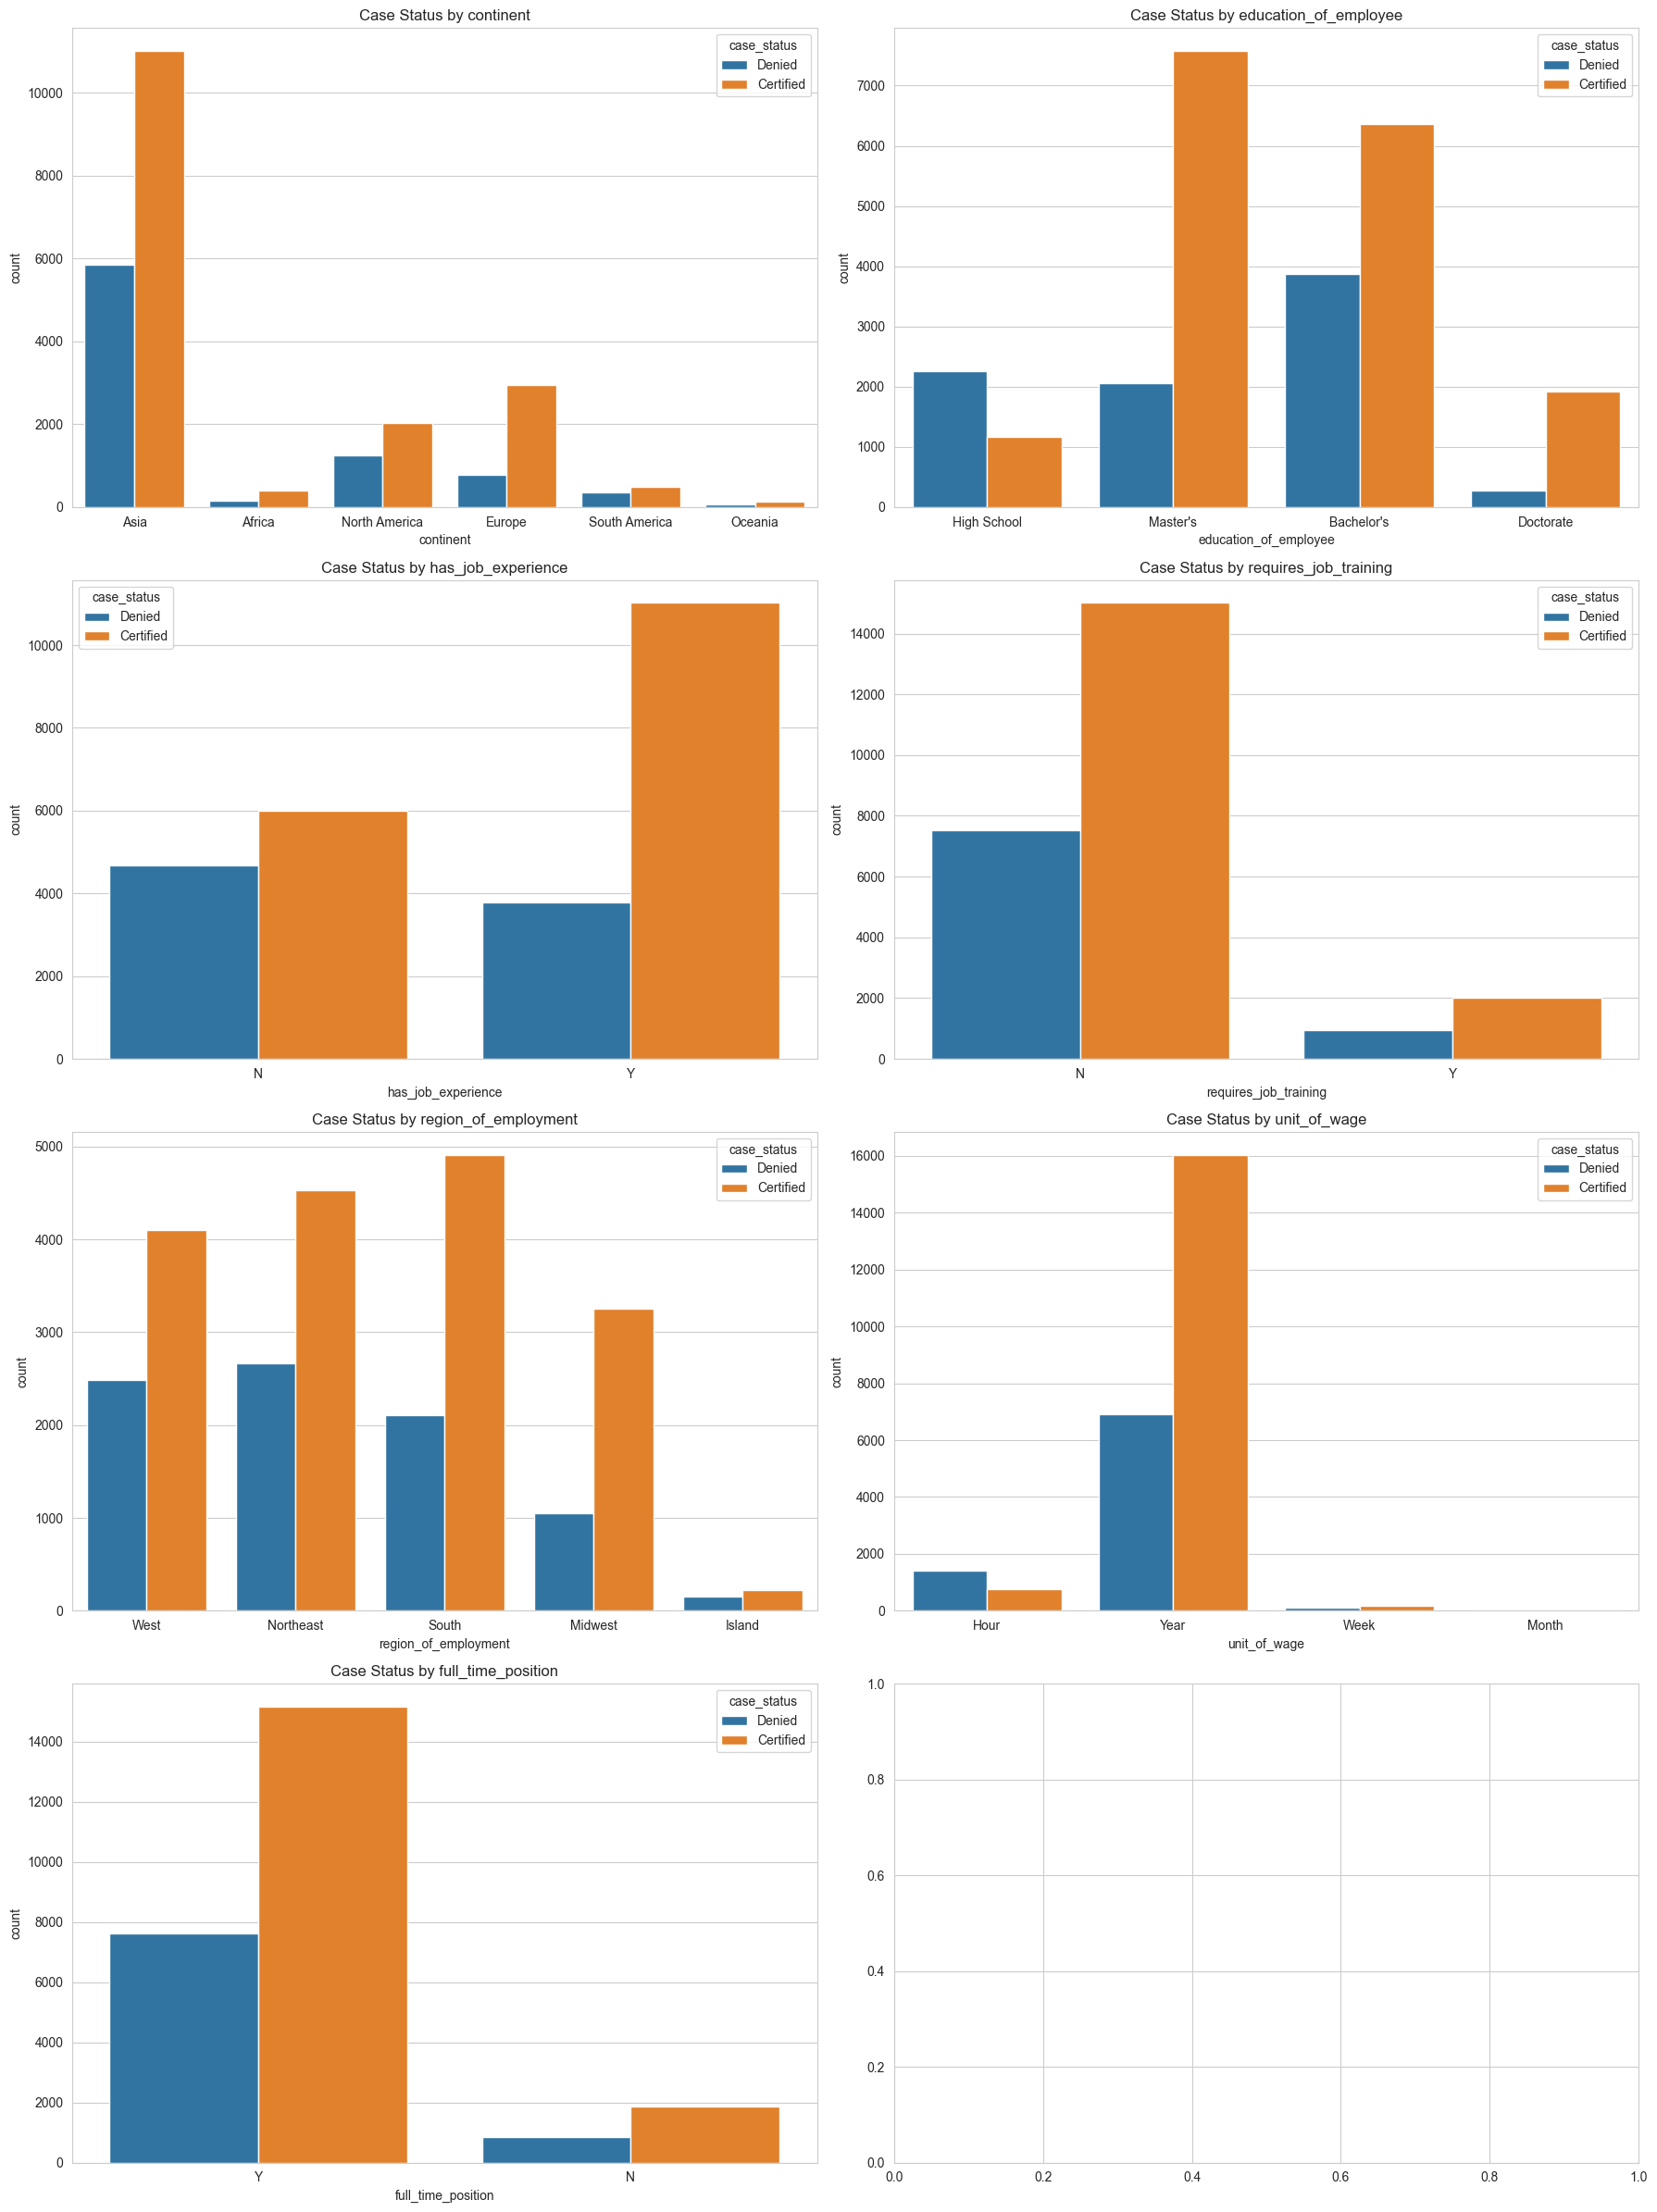

In [110]:
def plot_countplot_with_hue(ax: plt.Axes, data: pd.DataFrame, x_col: str, hue_col: str):
    """
    Takes a matplotlib axis, plots a countplot for a specific column, and breaks it down by a hue.
    """
    sns.countplot(x=x_col, hue=hue_col, data=data, ax=ax)
    ax.set_title(f'Case Status by {x_col}')


# Set up the plot grid
fig, axes = plt.subplots(4, 2, figsize=(18, 24))
axes_flat = axes.flatten()
for i, col in enumerate(categorical_features):
    plot_countplot_with_hue(
        ax=axes_flat[i],
        data=data,
        x_col=col,
        hue_col='case_status'
    )

plt.tight_layout()
plt.show()

#### Insights

## Numerical Features vs Case Status

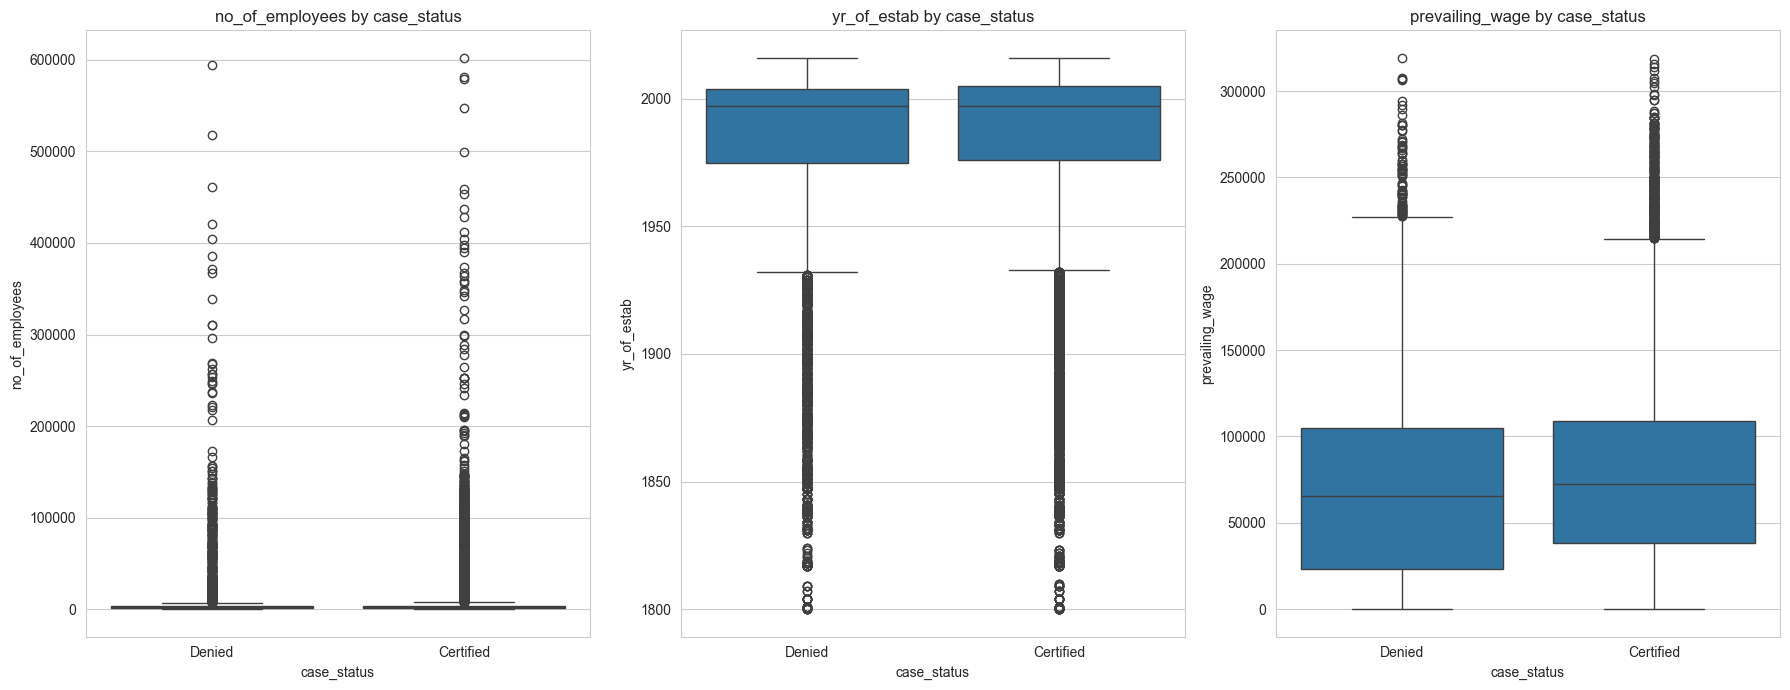

In [111]:
def plot_boxplot_on_ax(ax: plt.Axes, data: pd.DataFrame, x_col: str, y_col: str):
    """
    Takes a matplotlib axis and plots a boxplot for
    a given x and y column.
    """
    sns.boxplot(x=x_col, y=y_col, data=data, ax=ax)
    ax.set_title(f'{y_col} by {x_col}')


# Set up a figure for 3 plots
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# Loop through our features and the axes at the same time
for ax, y_feature in zip(axes, numerical_features):
    plot_boxplot_on_ax(
        ax=ax,
        data=data,
        x_col='case_status',
        y_col=y_feature
    )

plt.tight_layout()
plt.show()

#### Insight

For all three continuous features, the median and interquartile range (the "box") are very similar for both 'Y' and 'N' groups.

This suggests that there is no simple, linear relationship (e.g., "higher prevailing wage = approval"). The relationship is more complex. The outliers are present in both groups.


#### Scatter Plots

C:\Users\ncc\PycharmProjects\GEN-AI\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


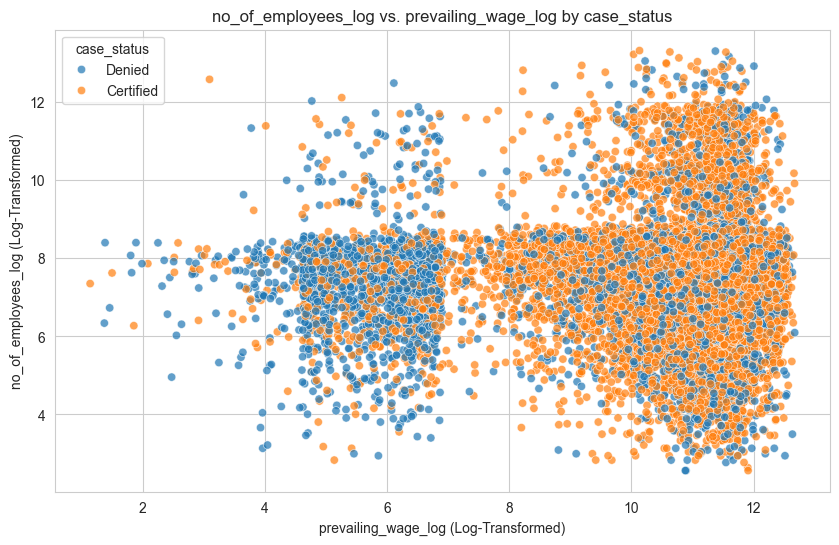

In [112]:
def create_log_transformed_df(df: pd.DataFrame, cols_to_transform: List[str]) -> pd.DataFrame:
    """
    Creates a new DataFrame with log-transformed (log1p) columns.
    Returns a copy, leaving the original DataFrame unchanged.
    """
    df_copy = df.copy()
    for col in cols_to_transform:
        df_copy[f'{col}_log'] = np.log1p(df_copy[col])
    return df_copy


def plot_scatterplot_with_hue(df: pd.DataFrame, x_col: str, y_col: str, hue_col: str):
    """
    Generates a styled scatter plot with a hue.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_col, y=y_col, hue=hue_col, data=df, alpha=0.7)
    plt.title(f'{y_col} vs. {x_col} by {hue_col}')
    plt.xlabel(f'{x_col} (Log-Transformed)')
    plt.ylabel(f'{y_col} (Log-Transformed)')
    plt.show()


plot_df = create_log_transformed_df(df=data, cols_to_transform=['prevailing_wage', 'no_of_employees'])

plot_scatterplot_with_hue(df=plot_df, x_col='prevailing_wage_log', y_col='no_of_employees_log', hue_col='case_status')

#### Insights:
```
As the prevailing wage increases past a certain point, the frequency of approved applications increase regardless of the no_of_employees

This indicates that prevailing wage is a very strong factor

# Phase 3: Data Preprocessing
```
Task 3.1: Create new features that may help improve the model's performance.
Task 3.2: Encode categorical variables using one-hot or label encoding techniques.
Task 3.3: Normalize or standardize numerical features as needed.

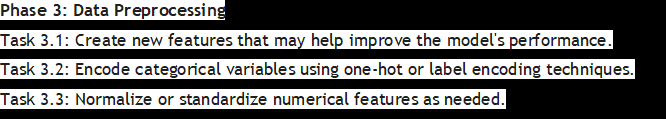

standardize all wages to a single, annual unit ('Year'). create a new feature called annual_wage.

    If unit_of_wage is 'Year', annual_wage = prevailing_wage

    If unit_of_wage is 'Month', annual_wage = prevailing_wage * 12

    If unit_of_wage is 'Week', annual_wage = prevailing_wage * 52

    If unit_of_wage is 'Hour', annual_wage = prevailing_wage * 40 (hours/week) * 52 (weeks/year)

This will make the prevailing_wage (and the new annual_wage) feature much more useful and will solve the outlier problem at the low end.

Creating engineered features ('annual_wage', 'company_age')...
Original columns dropped.

--- New 'annual_wage' feature ---
count    2.548000e+04
mean     1.973912e+05
std      5.785917e+05
min      1.000000e+02
25%      4.710796e+04
50%      8.283946e+04
75%      1.248250e+05
max      1.456915e+07
Name: annual_wage, dtype: float64


C:\Users\ncc\AppData\Local\Temp\ipykernel_16760\3547813380.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='case_status', y='annual_wage', data=df, palette='coolwarm')


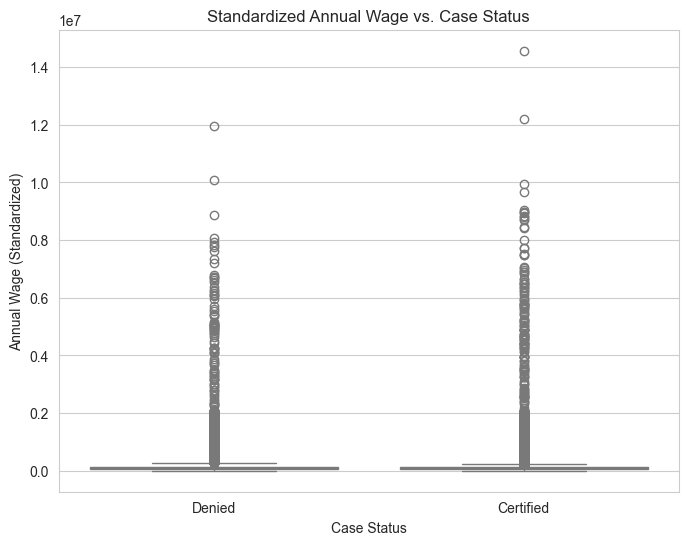

In [113]:
def calculate_annual_wage(row) -> float:
    """Converts a wage to an annual salary based on its unit."""
    wage = row['prevailing_wage']
    unit = row['unit_of_wage']

    if unit == 'Year':
        return wage
    elif unit == 'Month':
        return wage * 12
    elif unit == 'Week':
        return wage * 52
    elif unit == 'Hour':
        # Assuming a 40-hour work week
        return wage * 40 * 52
    return wage


def create_engineered_features(df: pd.DataFrame, reference_year: int) -> pd.DataFrame:
    """
    Takes the raw DataFrame and returns a new one with 'annual_wage'
    and 'company_age' features, dropping the original columns.
    Drops Case ID: Unnecessary Identifier
    """
    df_new = df.copy()
    df_new['annual_wage'] = df_new.apply(calculate_annual_wage, axis=1)
    df_new['company_age'] = reference_year - df_new['yr_of_estab']
    cols_to_drop = [
        'prevailing_wage', 'unit_of_wage',  # Replaced by annual_wage
        'yr_of_estab',  # Replaced by company_age
        'case_id'  # Irrelevant identifier
    ]
    df_new = df_new.drop(columns=cols_to_drop)
    return df_new


def plot_annual_wage_boxplot(df: pd.DataFrame):
    """Generates a styled boxplot for the annual wage vs. case status."""
    plt.figure(figsize=(8, 6))
    # Using 'x' for the categorical 'case_status' is more standard
    sns.boxplot(x='case_status', y='annual_wage', data=df, palette='coolwarm')
    plt.title('Standardized Annual Wage vs. Case Status')
    plt.ylabel('Annual Wage (Standardized)')
    plt.xlabel('Case Status')
    plt.show()


REFERENCE_YEAR = 2016
print("Creating engineered features ('annual_wage', 'company_age')...")
df_processed = create_engineered_features(data, reference_year=REFERENCE_YEAR)
print("Original columns dropped.")

# Describe new 'annual_wage' distribution
print("\n--- New 'annual_wage' feature ---")
print(df_processed['annual_wage'].describe())

# visualize it
plot_annual_wage_boxplot(df_processed)

## Encode categorical variables

## standardize numerical features



In [114]:
def encode_dataframe(df: pd.DataFrame, binary_map: Dict[str, int]) -> pd.DataFrame:
    """
    Takes a DataFrame and applies all necessary encodings for modeling.
    Returns a new, fully encoded DataFrame.
    """
    df_encoded = df.copy()

    # 1. Encode the target variable (Explicitly)
    print("Mapping target variable 'case_status'...")
    target_map = {'Certified': 1, 'Denied': 0}
    df_encoded['case_status'] = df_encoded['case_status'].map(target_map)
    print("Mapping complete: Certified=1, Denied=0")

    # 2. Encode binary ('Y'/'N') features using the provided map
    binary_cols = [col for col in binary_map.keys() if col in df_encoded.columns]
    for col in binary_cols:
        df_encoded[col] = df_encoded[col].map(binary_map[col])

    # 3. One-hot encode multi-category features
    multi_cat_cols = ['continent', 'education_of_employee', 'region_of_employment']
    df_encoded = pd.get_dummies(df_encoded, columns=multi_cat_cols, drop_first=True)

    return df_encoded


def split_data(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Splits the DataFrame into features (X) and target (y), then into training and testing sets."""
    X = df.drop(columns=[target_col])
    y = df[target_col]

    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


def scale_features(
        X_train: pd.DataFrame, X_test: pd.DataFrame, numerical_cols: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """
    Fits a StandardScaler on the training data and transforms both training and testing data.
    Returns new scaled DataFrames and the fitted scaler object.
    """
    scaler = StandardScaler()

    # Create copies to avoid the SettingWithCopyWarning
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Fit on training data and transform both sets
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    return X_train_scaled, X_test_scaled, scaler


# Define the mapping for binary features to make the function more generic
BINARY_FEATURE_MAP = {
    'has_job_experience': {'Y': 1, 'N': 0},
    'requires_job_training': {'Y': 1, 'N': 0},
    'full_time_position': {'Y': 1, 'N': 0}
}
NUMERICAL_FEATURES = ['no_of_employees', 'company_age', 'annual_wage']

# 1. Encode the entire dataset first
print("Encoding DataFrame...")
df_final = encode_dataframe(df_processed, binary_map=BINARY_FEATURE_MAP)
print("Data after encoding:")
print(df_final.head())
print(f"\nTotal number of features after encoding: {len(df_final.columns) - 1}")

# 2. Split the encoded data into training and testing sets
print("\nSplitting data into training and testing sets (80/20 split)...")
X_train, X_test, y_train, y_test = split_data(df_final, target_col='case_status')
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# 3. Scale the numerical features using the train/test split
print("\nStandardizing numerical features...")
X_train_scaled, X_test_scaled, fitted_scaler = scale_features(X_train, X_test, NUMERICAL_FEATURES)
print("Numerical features standardized.")
print("\nFirst 5 rows of X_train (scaled):")
print(X_train_scaled.head())

Encoding DataFrame...
Mapping target variable 'case_status'...
Mapping complete: Certified=1, Denied=0
Data after encoding:
   has_job_experience  requires_job_training  no_of_employees  \
0                   0                      0            14513   
1                   1                      0             2412   
2                   0                      1            44444   
3                   0                      0               98   
4                   1                      0             1082   

   full_time_position  case_status  annual_wage  company_age  continent_Asia  \
0                   1            0  1231782.032            9            True   
1                   1            1    83425.650           14            True   
2                   1            0   122996.860            8            True   
3                   1            0    83434.030          119            True   
4                   1            1   149907.390           11           False   

   c

--- Training and Evaluating Models ---

--------- Processing: Logistic Regression ------------
Accuracy: 0.7188
AUC-ROC: 0.7489

Classification Report:
               precision    recall  f1-score   support

   Denied (0)       0.62      0.39      0.48      1692
Certified (1)       0.75      0.88      0.81      3404

     accuracy                           0.72      5096
    macro avg       0.68      0.64      0.64      5096
 weighted avg       0.70      0.72      0.70      5096


--------- Done With Processing: Logistic Regression ------------

--------- Processing: Decision Tree ------------
Accuracy: 0.6515
AUC-ROC: 0.6115

Classification Report:
               precision    recall  f1-score   support

   Denied (0)       0.48      0.49      0.48      1692
Certified (1)       0.74      0.73      0.74      3404

     accuracy                           0.65      5096
    macro avg       0.61      0.61      0.61      5096
 weighted avg       0.65      0.65      0.65      5096


--------

C:\Users\ncc\PycharmProjects\GEN-AI\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:58:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7210
AUC-ROC: 0.7520

Classification Report:
               precision    recall  f1-score   support

   Denied (0)       0.61      0.45      0.52      1692
Certified (1)       0.76      0.85      0.80      3404

     accuracy                           0.72      5096
    macro avg       0.68      0.65      0.66      5096
 weighted avg       0.71      0.72      0.71      5096


--------- Done With Processing: XGBoost ------------


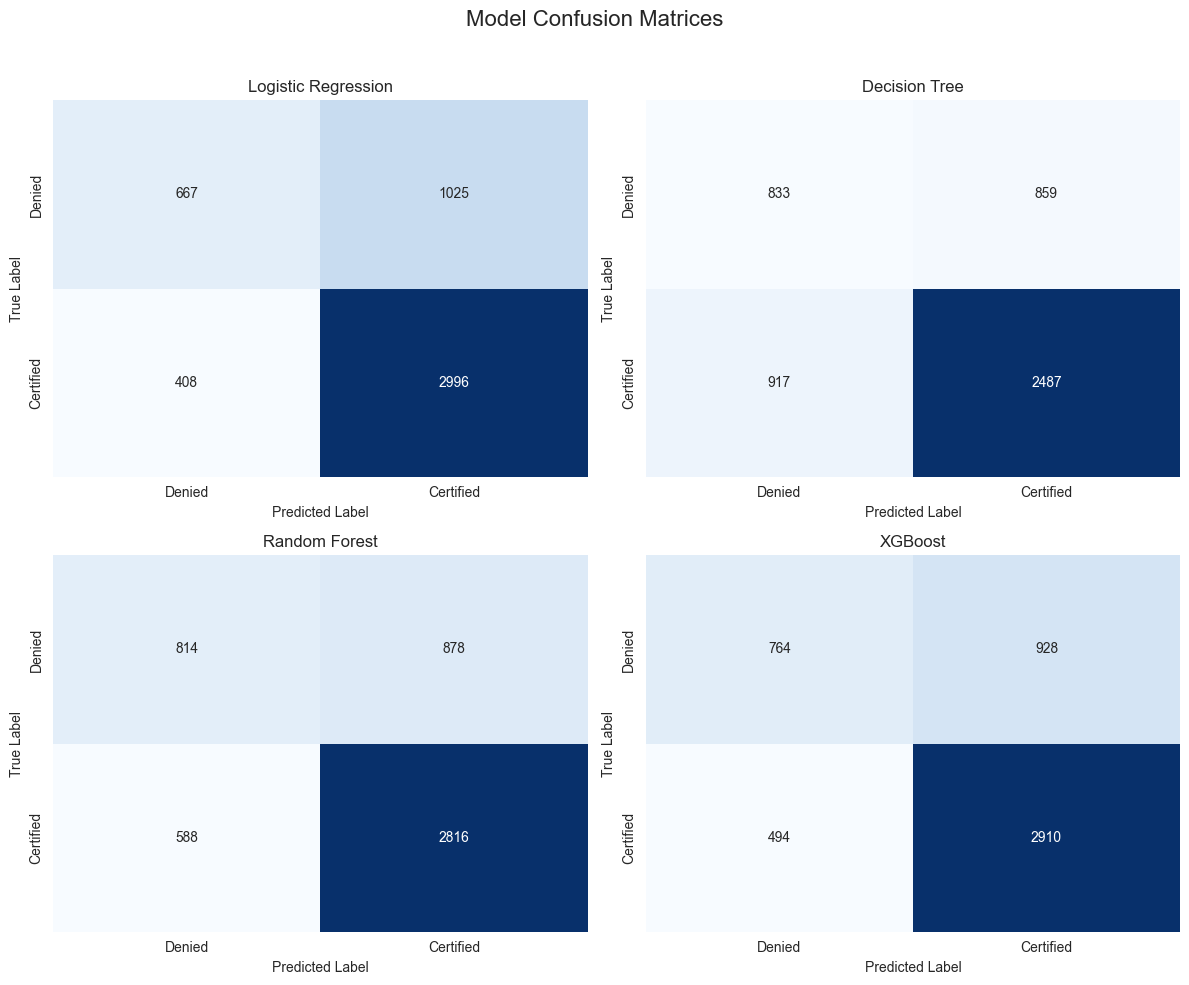

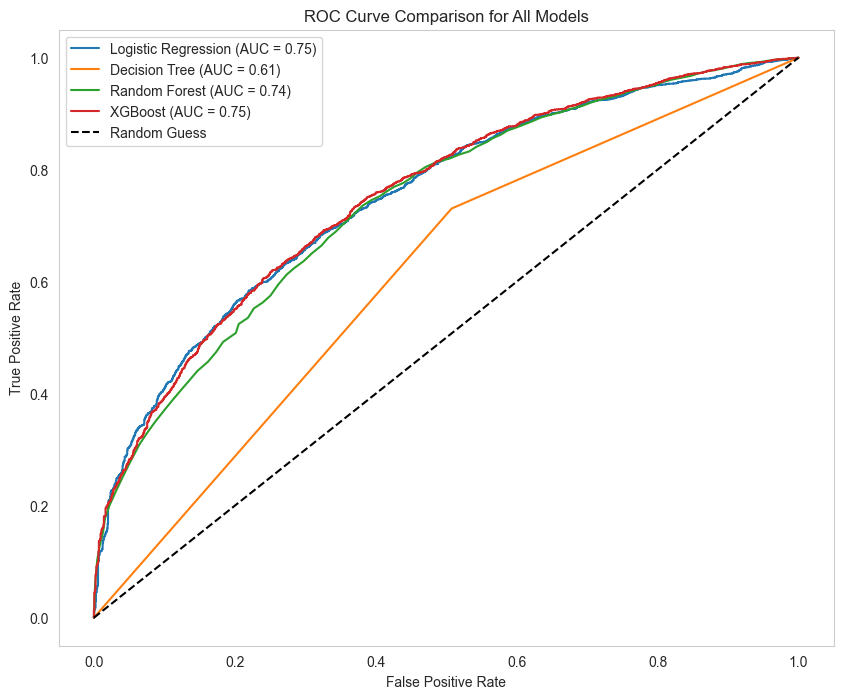


--- Final Model Comparison Summary (Sorted by F1-Score) ---
                     Accuracy   AUC-ROC  Precision (Certified)  \
Logistic Regression  0.718799  0.748861               0.745088   
XGBoost              0.720958  0.751974               0.758207   
Random Forest        0.712323  0.740607               0.762317   
Decision Tree        0.651491  0.611464               0.743276   

                     Recall (Certified)  F1-Score (Certified)  
Logistic Regression            0.880141              0.807003  
XGBoost                        0.854877              0.803645  
Random Forest                  0.827262              0.793463  
Decision Tree                  0.730611              0.736889  


In [115]:
def train_and_evaluate_model(
        model: ClassifierMixin,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_test: pd.DataFrame,
        y_test: pd.Series
) -> Dict[str, Any]:
    """
    Trains a given model and evaluates its performance on the test set.
    Returns a dictionary containing performance metrics and prediction results.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive AUC ROC class

    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Package the results into a dictionary
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_pred_proba),
        "Precision (Certified)": report['1']['precision'],
        "Recall (Certified)": report['1']['recall'],
        "F1-Score (Certified)": report['1']['f1-score'],
        "fpr": roc_curve(y_test, y_pred_proba)[0],  # False Positive Rate for ROC curve
        "tpr": roc_curve(y_test, y_pred_proba)[1],  # True Positive Rate for ROC curve
        "report_str": classification_report(y_test, y_pred, target_names=['Denied (0)', 'Certified (1)']),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    return metrics


def plot_confusion_matrix(ax: plt.Axes, conf_matrix: np.ndarray, title: str):
    """Takes a matplotlib axis and plots a confusion matrix on it."""
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticklabels(['Denied', 'Certified'])
    ax.set_yticklabels(['Denied', 'Certified'])


# Initialize the models to be tested
models_to_run = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# This will hold the results from each model run
all_results = {}

print("--- Training and Evaluating Models ---")

# Setup plots for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes_flat = axes.flatten()

# Loop, call our function, and store the results
for i, (name, model) in enumerate(models_to_run.items()):
    print(f"\n--------- Processing: {name} ------------")

    # Note: We are now using the scaled data from the previous step
    results = train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    all_results[name] = results

    # Print the text-based report
    print(f"Accuracy: {results['Accuracy']:.4f}")
    print(f"AUC-ROC: {results['AUC-ROC']:.4f}")
    print("\nClassification Report:")
    print(results['report_str'])

    # Generate the confusion matrix plot for this model
    plot_confusion_matrix(axes_flat[i], results['confusion_matrix'], title=name)
    print(f"\n--------- Done With Processing: {name} ------------")

# Display all confusion matrices together
fig.suptitle("Model Confusion Matrices", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Now, create a single plot for all ROC curves to compare them directly
plt.figure(figsize=(10, 8))
for name, results in all_results.items():
    plt.plot(results['fpr'], results['tpr'], label=f"{name} (AUC = {results['AUC-ROC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for All Models')
plt.legend()
plt.grid()
plt.show()

# Finally, convert results to a DataFrame for easy comparison
# We exclude the raw plot data (fpr, tpr, etc.) from the summary table
summary_results = {name: {k: v for k, v in res.items() if isinstance(v, (int, float))}
                   for name, res in all_results.items()}
results_df = pd.DataFrame(summary_results).T.sort_values(by="F1-Score (Certified)", ascending=False)

print("\n--- Final Model Comparison Summary (Sorted by F1-Score) ---")
print(results_df)

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, classification_report
from typing import Dict, Any


def tune_model_with_gridsearch(
        estimator: ClassifierMixin,
        param_grid: Dict[str, Any],
        X_train: pd.DataFrame,
        y_train: pd.Series
) -> ClassifierMixin:
    """
    Performs a GridSearchCV to find the best model.

    Optimizes for the F1-score of the positive class ('Certified').
    """
    # We optimize for the F1 score of the positive class (Certified = 1)
    f1_scorer = make_scorer(f1_score, pos_label=1)

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    print(f"Starting GridSearchCV for {estimator.__class__.__name__}...")
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters found: {grid_search.best_params_}")
    return grid_search.best_estimator_


def evaluate_tuned_model(
        model: ClassifierMixin,
        X_test: pd.DataFrame,
        y_test: pd.Series
) -> Dict[str, Any]:
    """Evaluates the tuned model and returns a dictionary of metrics."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_pred_proba),
        "Report_Str": classification_report(y_test, y_pred, target_names=['Denied (0)', 'Certified (1)']),
        "F1-Score (Tuned)": f1_score(y_test, y_pred, pos_label=1)
    }
    return metrics


# ---

# Task 4.4: Perform hyperparameter tuning for XGBoost
print("--- Task 4.4: Hyperparameter Tuning for XGBoost ---")

# Calculate scale_pos_weight for handling imbalance
# This is count(negative_class) / count(positive_class)
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Calculated 'scale_pos_weight' for imbalance: {scale_pos_weight:.2f}")

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [5, 10],  # Max depth of trees
    'learning_rate': [0.05, 0.1],  # Step size shrinkage
    'scale_pos_weight': [scale_pos_weight]  # Handle class imbalance
}

# Create the base model
xgb_base = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Run the tuning function
best_xgb_model = tune_model_with_gridsearch(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    X_train=X_train_scaled,
    y_train=y_train
)

# --- Task 4.5: Evaluate the best-performing model ---
print("\n--- Task 4.5: Evaluating Tuned XGBoost Model ---")

tuned_results = evaluate_tuned_model(best_xgb_model, X_test_scaled, y_test)

print(f"Accuracy: {tuned_results['Accuracy']:.4f}")
print(f"AUC-ROC: {tuned_results['AUC-ROC']:.4f}")
print("\nClassification Report (Tuned Model):")
print(tuned_results['Report_Str'])

# --- Comparison ---
print("\n--- Comparison ---")
# Get the baseline F1-score from our previous cell's results
baseline_xgb_f1 = results_df.loc['XGBoost', 'F1-Score (Certified)']
print(f"Baseline XGBoost F1-Score (Certified): {baseline_xgb_f1:.4f}")
print(f"Tuned XGBoost F1-Score (Certified): {tuned_results['F1-Score (Tuned)']:.4f}")

--- Task 4.4: Hyperparameter Tuning for XGBoost ---
Calculated 'scale_pos_weight' for imbalance: 0.50
Starting GridSearchCV for XGBClassifier...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\ncc\PycharmProjects\GEN-AI\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:58:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': np.float64(0.49728220949023066)}

--- Task 4.5: Evaluating Tuned XGBoost Model ---
Accuracy: 0.7086
AUC-ROC: 0.7677

Classification Report (Tuned Model):
               precision    recall  f1-score   support

   Denied (0)       0.55      0.65      0.60      1692
Certified (1)       0.81      0.74      0.77      3404

     accuracy                           0.71      5096
    macro avg       0.68      0.69      0.68      5096
 weighted avg       0.72      0.71      0.71      5096


--- Comparison ---
Baseline XGBoost F1-Score (Certified): 0.8036
Tuned XGBoost F1-Score (Certified): 0.7723


In [117]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, f1_score
#
# # Task 4.4: Perform hyperparameter tuning
# print("--- Task 4.4: Hyperparameter Tuning for Random Forest (Revised: n_jobs=1) ---")
#
# # Define the same parameter grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20],
#     'class_weight': ['balanced', None]
# }
#
# # We will optimize for the F1 score of the positive class (Certified = 1)
# f1_scorer = make_scorer(f1_score, pos_label=1)
#
# # Initialize GridSearchCV
# # cv=3 means 3-fold cross-validation
# # n_jobs=1 runs on a single core, avoiding the pickling error
# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=42),
#     param_grid=param_grid,
#     scoring=f1_scorer,
#     cv=3,
#     n_jobs=1,  # Set to 1 to avoid parallel processing errors
#     verbose=1
# )
#
# # Fit the grid search on the TRAINING data
# print("Starting GridSearchCV... (This may take a few minutes)")
# grid_search.fit(X_train, y_train)
#
# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"\nBest parameters found: {best_params}")
#
# # --- Task 4.5: Evaluate the best-performing model ---
# print("\n--- Task 4.5: Evaluating Tuned Model ---")
#
# # Get the best model from the grid search
# best_rf_model = grid_search.best_estimator_
#
# # Make predictions on the test set
# y_pred_tuned = best_rf_model.predict(X_test)
# y_pred_proba_tuned = best_rf_model.predict_proba(X_test)[:, 1]
#
# # Evaluate performance
# accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
# auc_roc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
#
# print(f"--- Results for Tuned Random Forest ---")
# print(f"Accuracy: {accuracy_tuned:.4f}")
# print(f"AUC-ROC: {auc_roc_tuned:.4f}")
# print("\nClassification Report (Tuned Model):")
# print(classification_report(y_test, y_pred_tuned, target_names=['Denied (0)', 'Certified (1)']))
#
# # Compare with baseline Random Forest
# print("\n--- Comparison ---")
# print("Baseline Random Forest F1-Score (Certified): 0.531")
# f1_tuned = f1_score(y_test, y_pred_tuned, pos_label=1)
# print(f"Tuned Random Forest F1-Score (Certified): {f1_tuned:.4f}")
#
# # Store the final model and feature names for later
# final_model = best_rf_model
# feature_names = X_train.columns.tolist()

--- Task 5.1 & 5.2: Interpreting the Best Model ---
--- Feature Importances (from Tuned XGBoost) ---
education_of_employee_High School    0.319187
has_job_experience                   0.135579
education_of_employee_Master's       0.110198
education_of_employee_Doctorate      0.086095
continent_Europe                     0.074048
region_of_employment_Midwest         0.046948
region_of_employment_West            0.030091
full_time_position                   0.029322
region_of_employment_South           0.028499
continent_North America              0.022211
annual_wage                          0.022121
region_of_employment_Northeast       0.020788
continent_South America              0.016489
continent_Asia                       0.015143
continent_Oceania                    0.014558
requires_job_training                0.014340
company_age                          0.007315
no_of_employees                      0.007069
dtype: float32


C:\Users\ncc\AppData\Local\Temp\ipykernel_16760\2223804353.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_series.values, y=importance_series.index, palette='rocket')


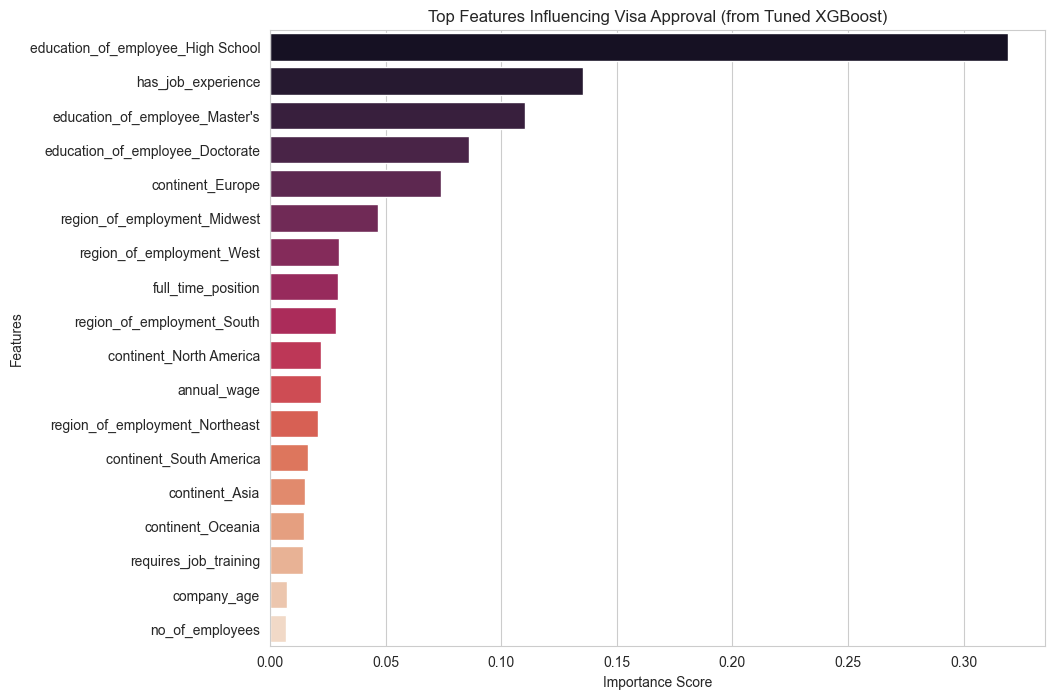

In [118]:
def get_feature_importances(model: ClassifierMixin, feature_names: List[str]) -> pd.Series:
    """
    Extracts feature importances from a trained model
    and returns them as a sorted Series.
    """
    importances = model.feature_importances_
    importance_series = pd.Series(importances, index=feature_names)
    return importance_series.sort_values(ascending=False)


def plot_feature_importances(importance_series: pd.Series):
    """
    Takes a sorted Series of feature importances and plots
    them as a horizontal bar chart.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importance_series.values, y=importance_series.index, palette='rocket')
    plt.title('Top Features Influencing Visa Approval (from Tuned XGBoost)')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()


# ---

# Task 5.1 & 5.2: Model Interpretation and Reporting
print("--- Task 5.1 & 5.2: Interpreting the Best Model ---")

# We'll use the best model from the tuning step in Cell 29
final_model = best_xgb_model

# We get the feature names from our scaled training data
feature_names = X_train_scaled.columns.tolist()

# 1. Get the feature importance data
feature_importances = get_feature_importances(final_model, feature_names)

# 2. Print the results
print("--- Feature Importances (from Tuned XGBoost) ---")
print(feature_importances)

# 3. Plot the results
#
plot_feature_importances(feature_importances)

--- Grouping Feature Importances ---
education_of_employee    0.515480
continent                0.142449
has_job_experience       0.135579
region_of_employment     0.126325
full_time_position       0.029322
annual_wage              0.022121
requires_job_training    0.014340
company_age              0.007315
no_of_employees          0.007069
dtype: float64


C:\Users\ncc\AppData\Local\Temp\ipykernel_16760\1943946570.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_series.values, y=importance_series.index, palette='viridis')


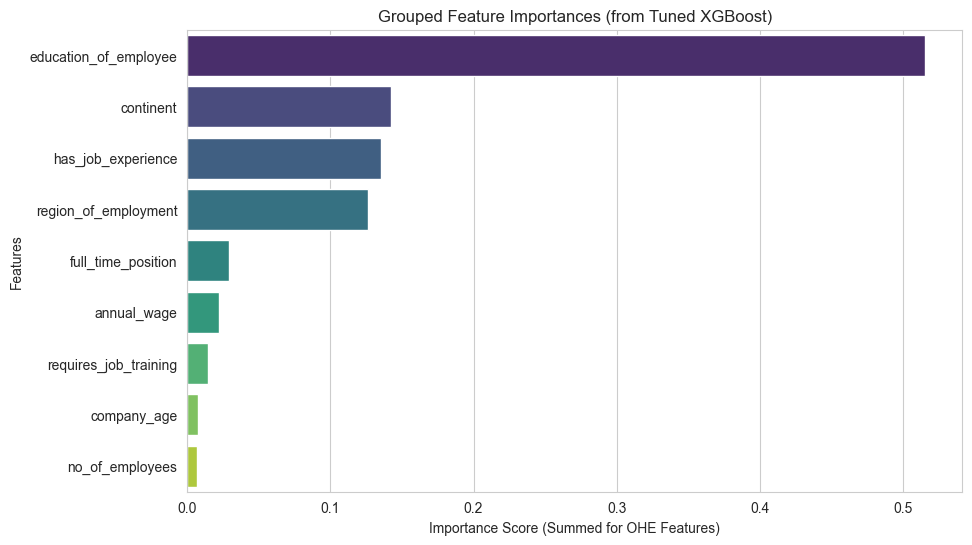

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def get_grouped_feature_importances(importance_series: pd.Series) -> pd.Series:
    """
    Groups importances from one-hot encoded features by summing them.

    Note: This is an underestimate due to `drop_first=True`.
    """

    # Start with the features that are already single
    grouped_importances = importance_series.to_dict()

    # Define the OHE groups
    ohe_groups = {
        'education_of_employee': 'education_of_employee_',
        'continent': 'continent_',
        'region_of_employment': 'region_of_employment_'
    }

    # Store the new summed importances
    new_sums = {}

    # Loop through each group
    for group_name, prefix in ohe_groups.items():
        # Find all features that match the prefix
        keys_to_sum = [key for key in grouped_importances.keys() if key.startswith(prefix)]

        # Calculate the sum
        group_sum = sum(grouped_importances[key] for key in keys_to_sum)

        # Remove the individual OHE features
        for key in keys_to_sum:
            del grouped_importances[key]

        # Add the new grouped feature
        new_sums[group_name] = group_sum

    # Add the new sums to the dictionary
    grouped_importances.update(new_sums)

    # Convert back to a sorted Series
    return pd.Series(grouped_importances).sort_values(ascending=False)


def plot_grouped_importances(importance_series: pd.Series):
    """Plots the new grouped feature importances."""
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance_series.values, y=importance_series.index, palette='viridis')
    plt.title('Grouped Feature Importances (from Tuned XGBoost)')
    plt.xlabel('Importance Score (Summed for OHE Features)')
    plt.ylabel('Features')
    plt.show()


# ---

# We'll use 'feature_importances' from the previous cell (Cell 30)
print("--- Grouping Feature Importances ---")

grouped_importances = get_grouped_feature_importances(feature_importances)

print(grouped_importances)

# Plot the new, grouped importances
#
plot_grouped_importances(grouped_importances)

In [120]:
import joblib

# 'final_model' is the tuned XGB Boost Model
# 'fitted_scaler' is the StandardScaler object
# 'feature_names' is the list of 18 column names

joblib.dump(final_model, 'easy_visa_model.pkl')
joblib.dump(fitted_scaler, 'easy_visa_scaler.pkl')
joblib.dump(feature_names, 'easy_visa_features.pkl')

print("Model, scaler, and feature list saved.")

Model, scaler, and feature list saved.
